In [1]:
import os
BASE_DIR = os.getcwd()
print(BASE_DIR)

## Importing libraries

In [2]:
import cv2
import errno
from text_segmentation import words, page
from htr.utils import implt

import string
from htr.generator import Tokenizer, DataGenerator

from htr.network import puigcerver, ctc_loss, ctc_decode
from tensorflow.keras.models import Model

import numpy as np
from htr.preprocessing import preprocess, normalization, threshold

from tqdm.notebook import tqdm
from fpdf import FPDF

In [3]:
def draw_boxes(img, boxes):
    img = img.copy()
    for x1, y1, x2, y2 in boxes:
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 240), 1)
    return img

## Steps

### Load image

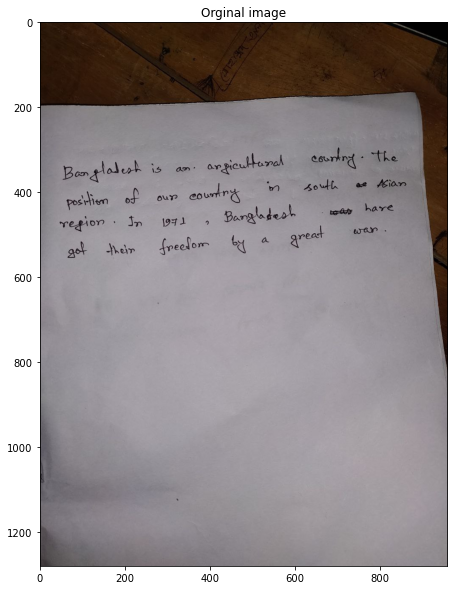

In [4]:
img = cv2.imread('images/eng-4.jpg')
implt(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), figsize=(20, 10), title='Orginal image')

### Page detection

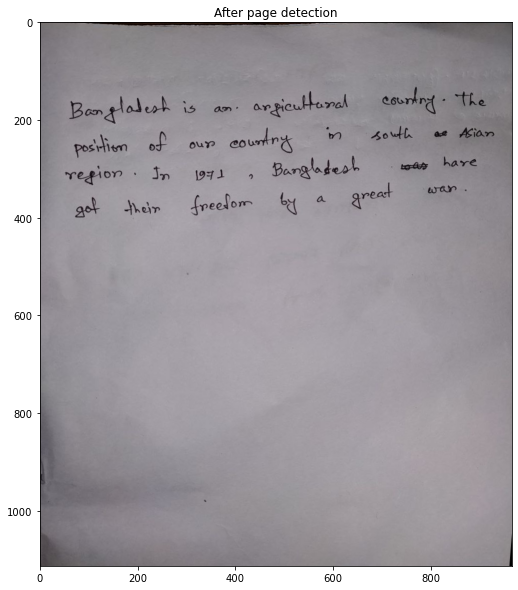

In [5]:
crop = page.detection(img)
implt(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB), figsize=(20, 10), title='After page detection')

### Word segmentation
Get bounding boxes for each words

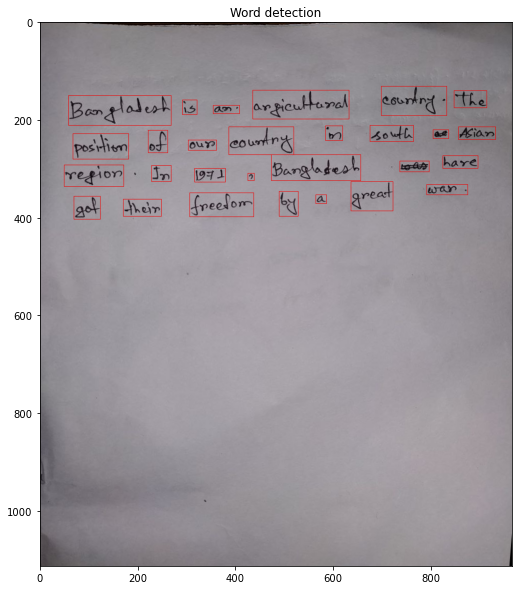

In [6]:
boxes = words.detection(crop)
implt(cv2.cvtColor(draw_boxes(crop, boxes), cv2.COLOR_BGR2RGB), figsize=(20, 10), title='Word detection')

### Get words from each line

In [7]:
lines = words.sort_words(boxes)

No. of lines: 6


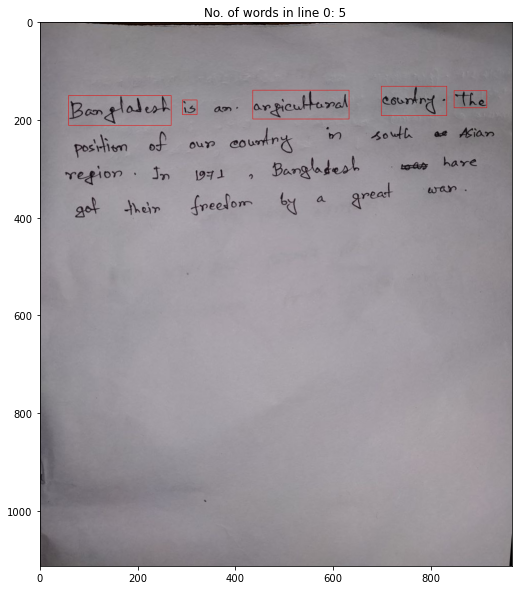

In [8]:
print('No. of lines:', len(lines))
#n = int(input('Select a line: '))
n=0

implt(cv2.cvtColor(draw_boxes(crop, lines[n]), cv2.COLOR_BGR2RGB), 
      figsize=(20, 10), 
      title=f'No. of words in line {n}: {len(lines[n])}')

### Binarization 

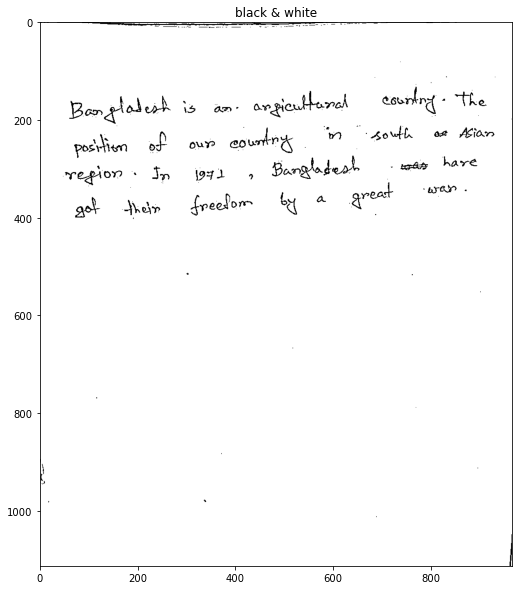

In [9]:
# crop.shape -> (H, W, C)
# crop_bw.shape -> (H, W)
crop_bw = threshold(crop, block_size=11)
implt(cv2.cvtColor(crop_bw, cv2.COLOR_GRAY2RGB), figsize=(20, 10), title='black & white')

### Set up parameters

In [10]:
# Parameters
input_size = (1024, 128, 1)
charset = string.printable[:95]
max_text_len = 128

# Filepaths
output_path = os.path.join(BASE_DIR, 'htr', 'data', 'output-english')
target_path = os.path.join(output_path, 'checkpoint_weights_english1.hdf5')

### Tokenizer for tokenizing and decoding predicted text

In [11]:
tokenizer = Tokenizer(charset=charset, max_text_len=max_text_len)

### Load pre-trained model

In [12]:
# Model
inputs, outputs = puigcerver(input_size=input_size, d_model=tokenizer.vocab_size + 1)
model = Model(inputs=inputs, outputs=outputs)

# Load weights from target_path
if os.path.isfile(target_path):
    model.load_weights(target_path)
    print('===== Pre-trained weights loaded =====')
else:
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), target_path)

===== Pre-trained weights loaded =====


### Predict
Get prediction of each image of each lines from the model, decode the predicted text.

In [13]:
output = ''
for line in tqdm(lines):
    imgs = []
    for x1, y1, x2, y2 in line:
        word = crop_bw[y1:y2, x1:x2]
        imgs.append(preprocess(img=word, input_size=input_size))
    
    X = normalization(imgs)
    Y_pred = model.predict(X)
    predictions, probabilities = ctc_decode(Y_pred)
    y = [tokenizer.decode(y) for y in predictions]
    output += ' '.join(y) + '\n'

#a variable pdf
pdf = FPDF()
#add a page 
pdf.add_page()
#save syle and size of font in the pdf
pdf.set_font("Arial","B",15)
pdf.write(4 ,output)
pdf.output("answer.pdf")
print(output)

1/1 [==============================] - 0s 312ms/step

Banglatest is angicutanal country the
an
position of our country in south o Asian
region In 171 Banglatesh # have
, by great wa.
got their freefom a



In [14]:
import pandas as pd 
import urllib
import requests
from bs4 import BeautifulSoup 
import re
import PyPDF2 as pdf

In [15]:
file=open('answer.pdf','rb')

In [16]:
soup = ('answer.pdf')

In [17]:
pdf_reader=pdf.PdfReader(file)

In [18]:
print(f"PDF Encrypted: {'Yes' if pdf_reader.is_encrypted else 'No'}")
print(f"Number of pages: {len(pdf_reader.pages)}")

PDF Encrypted: No
Number of pages: 1


In [19]:
page1=pdf_reader.pages[0]

lines = page1.extract_text().splitlines()
print(lines)

['Banglatest is angicutanal country theanposition of our country in south o Asianregion In 171 Banglatesh # have, by great wa.got their freefom a']


In [20]:
df = pd.DataFrame(lines, columns = ["text"])

In [21]:
df.replace (to_replace = [r'\\t|\\n|\\r','\t|\n|\r'], value = ['',''],regex = True ,inplace = True )

In [22]:
df = df.rename_axis("Id", axis = 'columns')

In [23]:
df.to_csv('random.csv',index_label="Id")

In [24]:
!pip install gensim 

In [25]:
import pandas as pd 
import gensim 
import os
import spacy
nlp = spacy.load('en_core_web_lg')
import nltk

In [26]:
data = pd.read_csv('random.csv')
data.head()

,Id,text
0,0,Banglatest is angicutanal country theanpositio...


In [27]:
#ref_sent = data.loc[data['Id']==3,'text'].iloc[0]
ref_sent1 = input("Enter the answer of definiton of full sentence:")

Enter the answer of definiton of full sentence:Bangladesh is an agricultural country


In [28]:
ref_sent1

'Bangladesh is an agricultural country'

In [29]:
ref_sent1_vec = nlp(ref_sent1) #vectorize reference sentence

In [30]:
all_docs = [nlp(row) for row in data ['text']]

In [31]:
sims = []
doc_id = []
for i in range (len(all_docs)):
    sim = all_docs[i].similarity(ref_sent1_vec)
    sims.append(sim)
    doc_id.append(i)
    sims_docs = pd.DataFrame(list(zip(doc_id,sims)), columns = ['doc_id','sims'])

In [32]:
sims_docs_sorted=sims_docs.sort_values(by = 'sims', ascending = False)

In [33]:
top10_sim_docs= data.iloc[sims_docs_sorted['doc_id'][:10]]

In [34]:
print(data[data["Id"]==5]['text'].values)

[]


In [35]:
top_sim_scores=pd.concat([top10_sim_docs, sims_docs_sorted['sims'][:10]], axis = 1)

In [36]:
for (text,sim) in zip(top_sim_scores['text'], top_sim_scores['sims']):
    print("the top 10 similar sentence are:{}\n with a similiarity score of {:.2f}\n".format(text,sim))

the top 10 similar sentence are:Banglatest is angicutanal country theanposition of our country in south o Asianregion In 171 Banglatesh # have, by great wa.got their freefom a
 with a similiarity score of 0.71



In [37]:
top1_sim_docs= data.iloc[sims_docs_sorted['doc_id'][:1]]

In [38]:
top_sim_scores1=pd.concat([top1_sim_docs, sims_docs_sorted['sims'][:1]], axis = 1)


In [39]:
for (text,sim) in zip(top_sim_scores1['text'], top_sim_scores1['sims']):
    print("the top 1 similar sentence are:{}\n with a similiarity score of {:.2f}\n".format(text,sim))
    x=print(sim)

the top 1 similar sentence are:Banglatest is angicutanal country theanposition of our country in south o Asianregion In 171 Banglatesh # have, by great wa.got their freefom a
 with a similiarity score of 0.71

0.7135658194181923


In [40]:
x=sim
print(x)

0.7135658194181923


C:\Users\ASUS\anaconda3\lib\site-packages\skfuzzy\control\term.py:74: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\ASUS\anaconda3\lib\site-packages\skfuzzy\control\term.py:74: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\ASUS\anaconda3\lib\site-packages\skfuzzy\control\term.py:74: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.7135658194181923
58.50977569855952


C:\Users\ASUS\anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


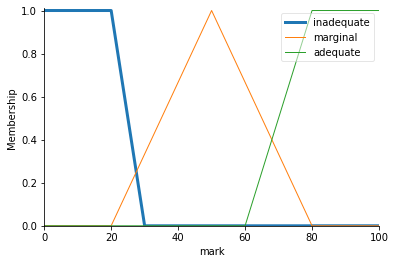

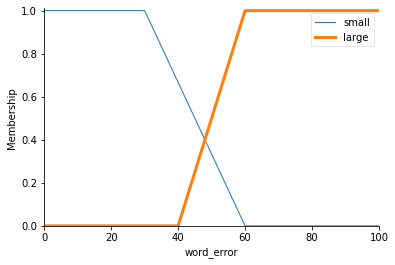

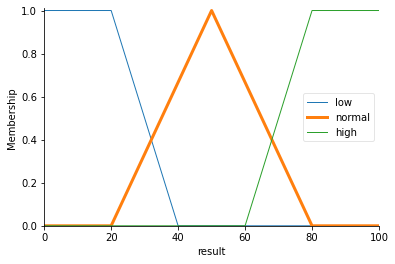

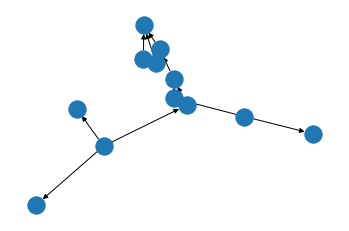

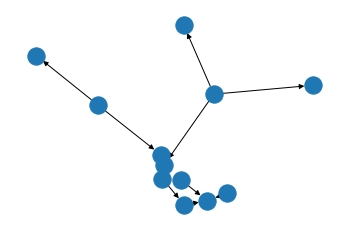

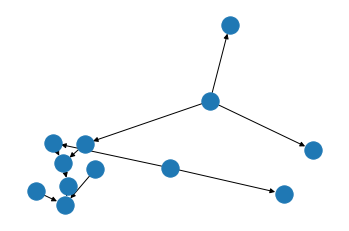

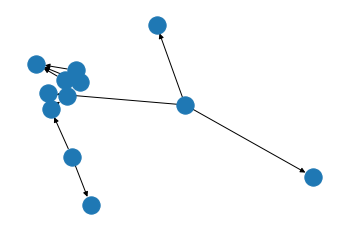

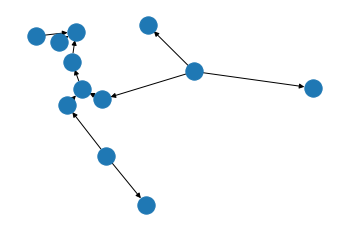

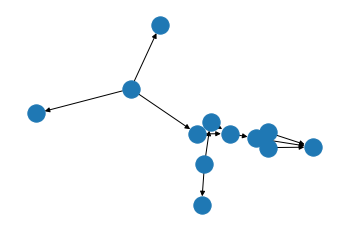

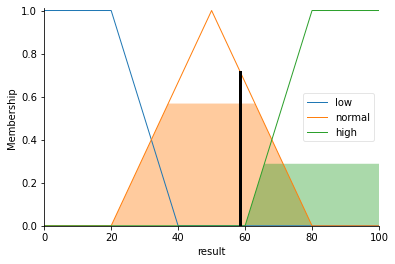

In [47]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl


mark = ctrl.Antecedent(np.arange(0, 110, 10), 'mark' )
word_error = ctrl.Antecedent(np.arange(0, 110, 10), 'word_error' )
result = ctrl.Consequent(np.arange(0, 110, 10), 'result' )
#Auto-membership function population is possible with .automf(3, 5, or 7)
#funding.automf(3)
#stuffing.automf(3)

mark[ 'inadequate' ] = fuzz.trapmf(mark.universe, [ 0, 0, 20, 30])
mark[ 'marginal' ] = fuzz.trimf(mark.universe, [ 20, 50, 80])
mark[ 'adequate' ] = fuzz.trapmf(mark.universe, [ 60, 80, 100, 100])

word_error[ 'small' ] = fuzz.trapmf(word_error.universe, [ 0, 0, 30, 60])
word_error[ 'large' ] = fuzz.trapmf(word_error.universe, [ 40, 60, 100, 100])
# Custom membership functions can be built interactively with a familiar,
# Pythonic API
result[ 'low' ] = fuzz.trapmf(result.universe, [ 0, 0, 20, 40])
result[ 'normal' ] = fuzz.trimf(result.universe, [ 20, 50, 80])
result[ 'high' ] = fuzz.trapmf(result.universe, [ 60, 80, 100, 100])


# You can see how these look with .view()
mark[ 'inadequate' ].view()
word_error['large'].view()
result['normal'].view()

rule1 = ctrl.Rule(mark[ 'adequate' ] | word_error[ 'small' ], result[ 'normal' ])
rule2 = ctrl.Rule(mark[ 'marginal' ] & word_error[ 'large' ], result[ 'high' ])
rule3 = ctrl.Rule(mark[ 'inadequate' ] & word_error[ 'small' ], result['low'])
rule4 = ctrl.Rule(mark['marginal'] & word_error['large'], result['high'])
rule5 = ctrl.Rule(mark['adequate']& word_error['small'], result['high'])
rule6 = ctrl.Rule(mark['inadequate']& word_error['large'],result['normal'])
rule1.view()
rule2.view()
rule3.view()
rule4.view()
rule5.view()
rule6.view()


calc_result_ctrl = ctrl.ControlSystem([rule1, rule2, rule3,rule4,rule5,rule6])
calc_result = ctrl.ControlSystemSimulation(calc_result_ctrl)
print(x)

# Pass inputs to the ControlSystem using Antecedent labels with Pythonic API
# Note: if you like passing many inputs all at once, use .inputs(dict_of_data)
calc_result.input[ 'mark' ] = x*100
calc_result.input[ 'word_error' ] = 70.1850
# Crunch the numbers
calc_result.compute()
print (calc_result.output[ 'result' ])
result.view(sim=calc_result)

In [42]:
import numpy as np
from sklearn.metrics import balanced_accuracy_score

#define array of actual classes
actual = np.repeat([1, 0], repeats=[20, 70])

#define array of predicted classes
pred = np.repeat([1, 0, 1, 0], repeats=[8, 12, 5, 65])

#calculate balanced accuracy score
balanced_accuracy_score(actual, pred)


0.6642857142857144

In [43]:
tp=12
fp=8
tn=40
fn=30
precision=(tp/(tp+fp))
recall=(tp/(tp+fn))
F1_Score=((2*precision*recall)/(precision+recall))
print("the pricision is :", precision)
print("the recall is :", recall )
print("the F1_Score is:",F1_Score )
print("The actual accuracy is:",balanced_accuracy_score(actual,pred))

the pricision is : 0.6
the recall is : 0.2857142857142857
the F1_Score is: 0.3870967741935483
The actual accuracy is: 0.6642857142857144
